In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import GridSearchCV


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings('ignore')

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.metrics import confusion_matrix, classification_report, f1_score


In [3]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/label_encoding_standard_scaling_data.csv", delimiter=",")
print(df.shape)
df.head()

(5976, 20)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,1,0,1,1,1.611381,1,2,2,1,1,1,1,1,1,2,0,1,-1.353483,-0.247769,0
1,0,0,0,0,0.468468,1,0,1,0,2,2,0,2,0,0,1,1,0.774066,0.736669,0
2,0,1,1,0,0.223558,1,2,1,0,0,0,0,0,0,0,1,0,0.335602,0.251453,1
3,1,0,0,0,-1.164265,1,0,0,0,0,0,0,0,2,0,1,2,-0.297182,-0.905725,0
4,1,0,0,0,-1.245901,1,0,0,2,0,2,0,0,0,0,0,2,-0.378564,-0.958057,0


In [4]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['Churn']),
                                                    df['Churn'],
                                                    test_size=0.3,
                                                    random_state=42)

In [5]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4183, 19), (1793, 19), (4183,), (1793,))

In [6]:
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()
numeric_features = X_train.select_dtypes(exclude=['object']).columns.tolist()
categorical_features, numeric_features

([],
 ['gender',
  'SeniorCitizen',
  'Partner',
  'Dependents',
  'tenure',
  'PhoneService',
  'MultipleLines',
  'InternetService',
  'OnlineSecurity',
  'OnlineBackup',
  'DeviceProtection',
  'TechSupport',
  'StreamingTV',
  'StreamingMovies',
  'Contract',
  'PaperlessBilling',
  'PaymentMethod',
  'MonthlyCharges',
  'TotalCharges'])

In [8]:
from xgboost import XGBClassifier
xgb = XGBClassifier(random_state=40)

In [14]:
numeric_transformer = Pipeline(steps=[
                                      ("knn_imputer", KNNImputer(n_neighbors=5).set_output(transform="pandas"))
                                      ])

numeric_transformer

Pipeline(steps=[('knn_imputer', KNNImputer())])

In [15]:
preprocessor = ColumnTransformer(transformers=[
                                               ("num", numeric_transformer,
                                                       numeric_features)]).set_output(transform="pandas")
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('knn_imputer',
                                                  KNNImputer())]),
                                 ['gender', 'SeniorCitizen', 'Partner',
                                  'Dependents', 'tenure', 'PhoneService',
                                  'MultipleLines', 'InternetService',
                                  'OnlineSecurity', 'OnlineBackup',
                                  'DeviceProtection', 'TechSupport',
                                  'StreamingTV', 'StreamingMovies', 'Contract',
                                  'PaperlessBilling', 'PaymentMethod',
                                  'MonthlyCharges', 'TotalCharges'])])

In [16]:
pipeline_xgb = Pipeline([("pre_process", preprocessor),
                         ("model", xgb)])
pipeline_xgb

Pipeline(steps=[('pre_process',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('knn_imputer',
                                                                   KNNImputer())]),
                                                  ['gender', 'SeniorCitizen',
                                                   'Partner', 'Dependents',
                                                   'tenure', 'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling'...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=40, ...))])

In [17]:
pipeline_xgb.fit(X_train, y_train)
y_pred = pipeline_xgb.predict(X_test)

In [18]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score
scores = {}
scores['xgb'] = round(f1_score(y_test, y_pred, average='weighted'), 3)

In [19]:
feature_names = pipeline_xgb['pre_process'].get_feature_names_out()
feature_names

array(['num__gender', 'num__SeniorCitizen', 'num__Partner',
       'num__Dependents', 'num__tenure', 'num__PhoneService',
       'num__MultipleLines', 'num__InternetService',
       'num__OnlineSecurity', 'num__OnlineBackup',
       'num__DeviceProtection', 'num__TechSupport', 'num__StreamingTV',
       'num__StreamingMovies', 'num__Contract', 'num__PaperlessBilling',
       'num__PaymentMethod', 'num__MonthlyCharges', 'num__TotalCharges'],
      dtype=object)

In [20]:
xgb_model = pipeline_xgb['model']
xgb_model.feature_importances_

array([0.02032135, 0.02464778, 0.01690866, 0.01933803, 0.03228726,
       0.02083303, 0.02420487, 0.09187253, 0.07681071, 0.02424974,
       0.0240688 , 0.03756967, 0.02387198, 0.02891319, 0.4425508 ,
       0.02656948, 0.0179363 , 0.02429755, 0.02274819], dtype=float32)

In [21]:
xgb_importances = pd.DataFrame(
    {"feature": feature_names, "importance": np.round(xgb_model.feature_importances_, 3)}
)
xgb_importances = xgb_importances.sort_values("importance", ascending=False).set_index(
    "feature"
)
xgb_importances.head(20)

,importance
feature,
num__Contract,0.443
num__InternetService,0.092
num__OnlineSecurity,0.077
num__TechSupport,0.038
num__tenure,0.032
num__StreamingMovies,0.029
num__PaperlessBilling,0.027
num__SeniorCitizen,0.025
num__OnlineBackup,0.024


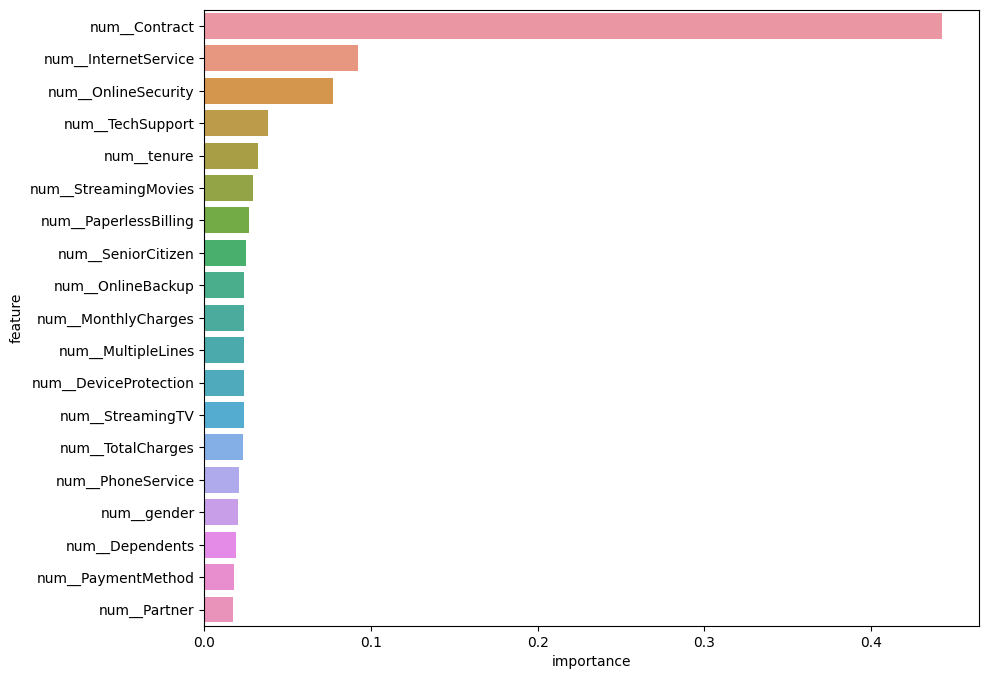

In [22]:
plt.figure(figsize=(10, 8))
sns.barplot(y=xgb_importances.head(30).index,
            x=xgb_importances.head(30).importance);

In [23]:
!pip install h2o

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.2/265.2 MB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for h2o: filename=h2o-3.44.0.3-py2.py3-none-any.whl size=265293968 sha256=edf0c7282f7370c1248d618a8c35ab030db6787117ddebfd0d23c29f85ab7cab
  Stored in directory: /root/.cache/pip/wheels/77/9a/1c/2da26f943fd46b57f3c20b54847b936b9152b831dc7447cf71
Successfully built h2o


In [24]:
!pip install tpot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.4/87.4 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 12.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for stopit: filename=stopit-1.1.2-py3-none-any.whl size=11937 sha256=84441de371658ea02b0ad2541f1bcb1cfdadc8e6bb1736b4f1733bb65b8f13ea
  Stored in directory: /root/.cache/pip/wheels/af/f9/87/bf5b3d565c2a007b4dae9d8142dccc85a9f164e517062dd519
Successfully built stopit


In [25]:
!pip install flaml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.2/295.2 kB 5.9 MB/s eta 0:00:00


In [26]:
import h2o
from h2o.automl import H2OAutoML

# Start the H2O cluster (locally)
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.21" 2023-10-17; OpenJDK Runtime Environment (build 11.0.21+9-post-Ubuntu-0ubuntu122.04); OpenJDK 64-Bit Server VM (build 11.0.21+9-post-Ubuntu-0ubuntu122.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpcrqqwur8
  JVM stdout: /tmp/tmpcrqqwur8/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpcrqqwur8/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,04 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.3
H2O_cluster_version_age:,22 hours and 1 minute
H2O_cluster_name:,H2O_from_python_unknownUser_fgnbl2
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.170 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [27]:
train_data = pd.concat([X_train, y_train], axis=1)
train_data = h2o.H2OFrame.from_python(train_data)
train_data['Churn'] = train_data['Churn'].asfactor()
train_data.head()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,0,-1.28672,1,2,0,0,0,0,0,0,0,0,1,2,-0.489841,-0.988577,0
1,0,0,0,-0.919355,1,2,0,0,0,0,0,2,2,0,1,1,0.242594,-0.661325,1
0,0,0,0,-0.266262,1,2,1,0,0,2,0,2,2,0,1,0,1.1843,0.132761,0
1,0,0,0,-0.715263,1,2,1,0,0,0,0,2,2,0,1,2,0.946795,-0.375301,1
1,0,1,1,-1.00099,1,0,2,1,1,1,1,1,1,2,0,3,-1.49964,-0.953329,0
1,0,0,0,-1.28672,1,0,0,0,0,2,0,0,0,0,1,2,-0.476554,-0.988401,1
1,0,0,1,-1.20508,1,0,1,0,0,0,0,0,0,0,0,2,0.159552,-0.913816,1
0,0,1,1,1.28483,1,2,2,1,1,1,1,1,1,2,1,3,-1.35514,-0.324948,0
1,1,1,0,1.24402,1,0,0,2,2,2,2,2,2,1,1,0,0.636216,1.33315,0
1,0,0,0,1.12156,1,2,1,0,0,2,0,2,0,2,1,2,0.82057,1.28989,0


In [28]:
aml = H2OAutoML(max_models=30, # hard total models experimented limit
                max_runtime_secs=300, # try to run as many models in 5 mins
                max_runtime_secs_per_model=30, # max training time for a model <= 30 s else move to next model
                seed=1)
aml.train(x=X_train.columns.tolist(), y="Churn", training_frame=train_data)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


key,value
Stacking strategy,cross_validation
Number of base models (used / total),4/6
# GBM base models (used / total),1/1
# XGBoost base models (used / total),1/1
# GLM base models (used / total),1/1
# DeepLearning base models (used / total),1/1
# DRF base models (used / total),0/2
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5


In [ ]:
lb = h2o.automl.get_leaderboard(aml, extra_columns = "ALL")
lb.head(lb.nrows)

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse,training_time_ms,predict_time_per_row_ms,algo
GBM_1_AutoML_1_20231221_123331,0.845586,0.41803,0.661959,0.23459,0.368348,0.13568,2942,0.063303,GBM
GBM_grid_1_AutoML_1_20231221_123331_model_2,0.844755,0.419542,0.65407,0.229487,0.368886,0.136077,365,0.028948,GBM
GLM_1_AutoML_1_20231221_123331,0.843921,0.421145,0.652482,0.234946,0.369782,0.136739,1129,0.004835,GLM
GBM_grid_1_AutoML_1_20231221_123331_model_4,0.842161,0.421252,0.658798,0.228611,0.370085,0.136963,872,0.02869,GBM
GBM_grid_1_AutoML_1_20231221_123331_model_3,0.84079,0.423308,0.653968,0.238532,0.371235,0.137816,450,0.039975,GBM
GBM_5_AutoML_1_20231221_123331,0.838591,0.426421,0.645491,0.23647,0.372553,0.138796,525,0.054854,GBM
GBM_2_AutoML_1_20231221_123331,0.837167,0.427865,0.647404,0.238084,0.372761,0.13895,805,0.046323,GBM
GBM_3_AutoML_1_20231221_123331,0.835148,0.431462,0.637327,0.248098,0.374787,0.140466,670,0.050212,GBM
XGBoost_grid_1_AutoML_1_20231221_123331_model_7,0.834263,0.435243,0.632988,0.236601,0.377586,0.142571,1791,0.01901,XGBoost
GBM_4_AutoML_1_20231221_123331,0.833454,0.433234,0.644614,0.246998,0.375768,0.141202,852,0.052699,GBM


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
              precision    recall  f1-score   support

           0       0.91      0.73      0.81      1321
           1       0.52      0.81      0.63       472

    accuracy                           0.75      1793
   macro avg       0.72      0.77      0.72      1793
weighted avg       0.81      0.75      0.76      1793



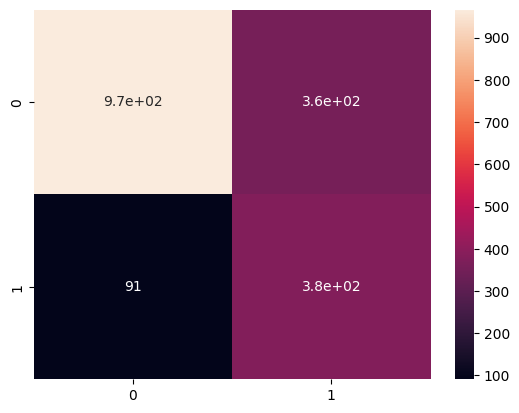

In [29]:
best_model =  aml.get_best_model(criterion="mean_per_class_error")
X_test_h2o = h2o.H2OFrame.from_python(X_test)
y_pred = best_model.predict(X_test_h2o)
y_pred = y_pred.as_data_frame()['predict'].values
cf = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))
sns.heatmap(cf, annot=True);